In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from numpy.random import randn
from scipy.stats import norm

%config InlineBackend.figure_format = 'retina' 
# this is just for Macbooks to create higher resolution previews of the plots in the notebook

# the lines below set a number of parameters for plotting, such as label font size, 
# title font size, which you may find useful
plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 16,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 3,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

In [259]:
# translational diffusion coefficient for T=300 K
def D_T(_eta,_R):
    kBT=4.14195e-21 # k_B * 300 K in J
    return(kBT/(6*np.pi*_eta*_R)) # diffusion constant returned in m^2/s

# rotational diffusion coefficient for T=300 K
def D_R(_eta,_R):
    kBT=4.14195e-21 # k_B * 300 K in J
    return(kBT/(8*np.pi*_eta*_R**3)) # diffusion constant returned in m^2/s

In [982]:
class particle:
    
    def __init__(self,_pos,_D,_v,_dt,_N,_id):
        self.dt=_dt
        self.D=_D
        self.v=_v
        self.sigma=np.sqrt(2*_D*dt)
        self.pos=_pos
        self.trajectory=[]
        self.trajectory.append(self.pos)
        self.N=_N
        self.c_step=0
        self.id=_id
        self.direction=np.zeros(2)
               
    def step(self):             
        #self.c_step=self.c_step+1
        self.pos=self.pos+self.sigma*randn(2)+self.v*self.direction*self.dt        
        self.trajectory.append(self.pos)                     
        
    def get_dpos(self,_delay):
        if _delay<=len(self.trajectory):     
            return(np.array(self.trajectory[-_delay]))
        else:
            return(self.pos)


In [983]:
class controller:
    
    def __init__(self,_particles,_delay,_req):
        self.particles=_particles
        self.delay=_delay
        self.req=_req
        
    def step(self):        
        for p in self.particles:
            p.direction=np.zeros(2)
            for pa in self.particles:
                if p.id!=pa.id:      
                    #print(pa.pos, pa.get_dpos(self.delay))
                    dist=pa.get_dpos(self.delay)-p.get_dpos(self.delay)
                    d=np.linalg.norm(dist)
                    if d>self.req:
                        p.direction=p.direction+dist/d
                    else:
                        p.direction=p.direction-dist/d
            if np.linalg.norm(p.direction)!=0:
                p.direction=p.direction/np.linalg.norm(p.direction)
              
        for p in self.particles:
            p.step()
                      

In [984]:
dt=0.11 # 50 ms time resolution
print('Omega=',1/(4*dt))
a=5e-6  # particle radius
eta=1e-3  # viscosity of water
v=3  #  µm/s velocity
D=D_T(eta,a)*1e12   # µm^2/s diffusion coefficient
Dr=D_R(eta,a)   # 0.1 rad^2/s rotational diffusion
N=10000 # number of steps
bond_length=7
delay=2

Omega= 2.272727272727273


In [985]:
n_part=2
part=[]
for i in range(n_part):
    x,y=5*np.array([np.random.rand(),np.random.rand()])
    part.append(particle(np.array([x,y]),D,v,dt,N,i))

c=controller(part,delay,7)

for i in range(N-1):
    c.step()

In [987]:
com=np.zeros([len(p.trajectory),2])
for p in part:
    com=com+p.trajectory
com=com/n_part

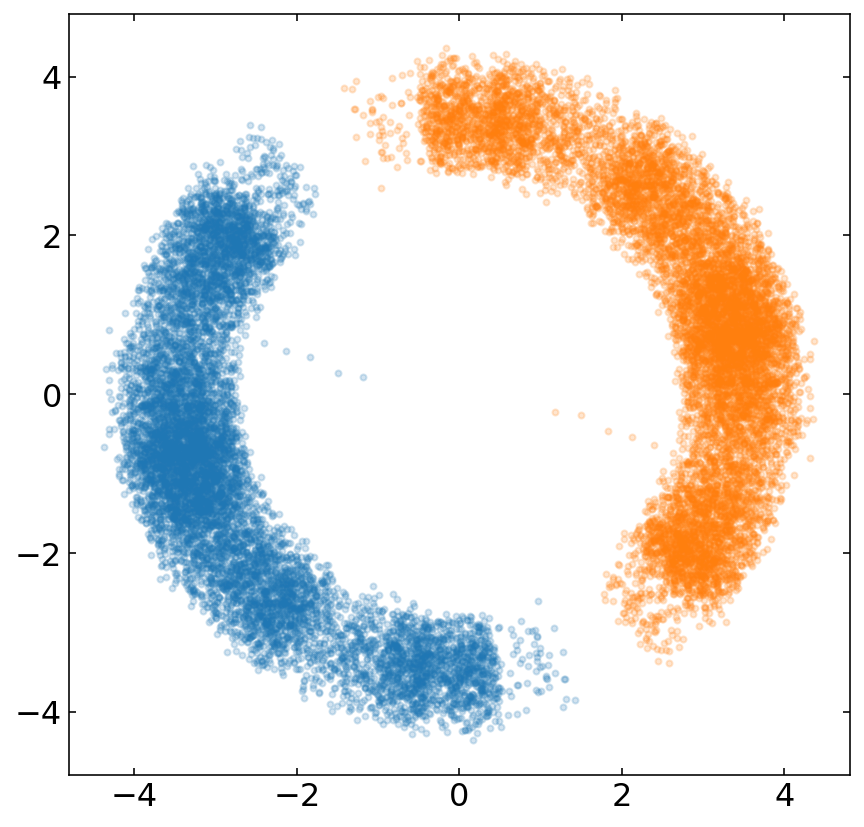

In [989]:
plt.figure(figsize=(7,7))
for i in range(n_part):
    plt.plot((part[i].trajectory-com)[:,0],(part[i].trajectory-com)[:,1],'o',lw=1,ms=3,alpha=0.2)


In [990]:
df=pd.DataFrame({'x':np.array(part[1].trajectory)[:,0],'y':np.array(part[1].trajectory)[:,1],'frame': range(len(com))})

In [991]:
def msd(_df,_dt,_N=5000):
    msd=np.zeros(_N)
    time=np.array(range(_N))*_dt
    for i in range(_N):
        msd[i]=np.mean(_df.x.diff(i).dropna()**2+np.mean(_df.y.diff(i).dropna()**2))
    return(time,msd)

In [992]:
time,MSD=msd(df,dt)

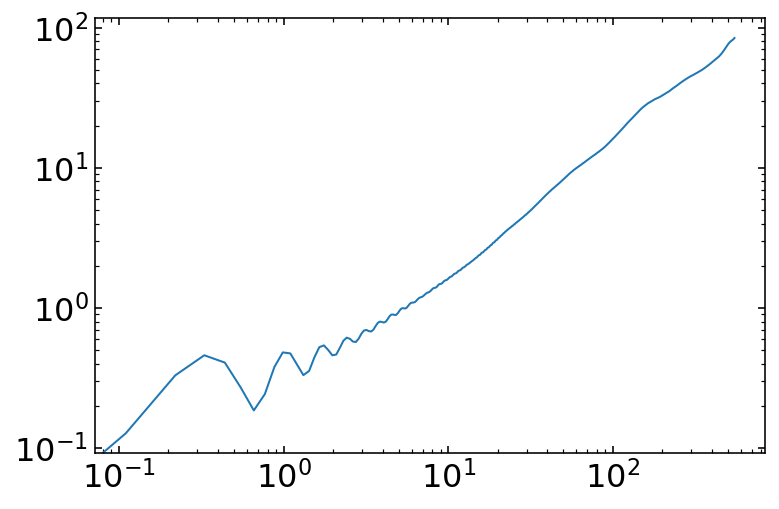

In [997]:
plt.loglog(time,MSD)